In [1]:
import numpy as np
import torch.nn as nn
import torch
import pandas as pd
import yaml
import sys
import copy
sys.path.append('..')
from fine_tune import FineTune
import pandas as pd
from transfer.target_dataset import target_dataset,target_wrapper
from dataset.tmQM_data import tmQM_wrapper
from models.sc_net import SCnet
import shutil
import os

In [2]:
config = yaml.load(open("config_f.yaml", "r"), Loader=yaml.FullLoader)
pre_train_path = './experiment/MPNN_se_att16_laplace_2d_2d_1/Jan16_15-05-05_MPNN_se_att16_laplace_2d_2d_1/checkpoints/'

In [4]:
for i in range(100):
    dataset = target_dataset(metal_list=['Cu'])
    data_loader = target_wrapper(predata=dataset,**config['data'])
    model = SCnet(
            GNN_config=config['GNN'],
            Coor_config=config['Coor_config'],
            out_dimention=config['out_dimention'],
            separated=config['separated'],
            attention=config['attention'],
            gnn=config['model']
        )
    cu_model = FineTune(config=config,dataset=data_loader,model_path=pre_train_path)
    cu_model.train(show_loss=False)
    train,valid,file_path = cu_model.train_result(plot=False)
    if train>0.9 and valid>0.8:
        print(f'Train:{train},valid:{valid}')
    else:
        shutil.rmtree(file_path)


Dataset generating......
Dataset generating......
Dataset generating......
Dataset generating......
Dataset generating......
Dataset generating......
Dataset generating......
Dataset generating......
Dataset generating......
Dataset generating......
Dataset generating......
Dataset generating......
Dataset generating......
Dataset generating......
Dataset generating......
Dataset generating......
Dataset generating......
Dataset generating......
Dataset generating......
Dataset generating......
Dataset generating......
Dataset generating......
Dataset generating......
Dataset generating......
Dataset generating......
Dataset generating......
Dataset generating......
Dataset generating......
Dataset generating......
Dataset generating......
Dataset generating......
Dataset generating......
Dataset generating......
Train:0.9416607868418916,valid:0.9249009479882159
Dataset generating......
Dataset generating......
Dataset generating......
Dataset generating......
Dataset generating......


In [8]:
temp = os.listdir('./experiment/finetune/2D/')
dataset = target_dataset(metal_list=['Cu'])
data_loader = target_wrapper(predata=dataset,**config['data'])
train,valid,test = data_loader.get_data_loaders()
path_list = ['./experiment/finetune/2D/'+p+'/checkpoints/' for p in temp]
preds = [[] for i in range(len(path_list))]
label = []
models = [FineTune(config=config,model_path=path_list[i]) for i in range(len(path_list))]
for _,data in enumerate(train):
    for i,path in enumerate(path_list):
        preds[i].append(models[i].predict(data))
    label.append(data.y)

Dataset generating......
normalizer!
normalizer!
normalizer!
normalizer!
normalizer!
normalizer!
normalizer!
normalizer!
normalizer!
normalizer!
normalizer!
normalizer!
normalizer!


In [9]:
temp = [np.concatenate(pred,axis=0)[np.newaxis,:] for pred in preds]
preds = np.concatenate(temp,axis=0)
pred = preds.mean(axis=0).tolist()

c:\Users\admin\Anaconda3\envs\PyG\lib\site-packages\numpy\core\shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
c:\Users\admin\Anaconda3\envs\PyG\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


ValueError: x and y must have same first dimension, but have shapes (3,) and (83,)

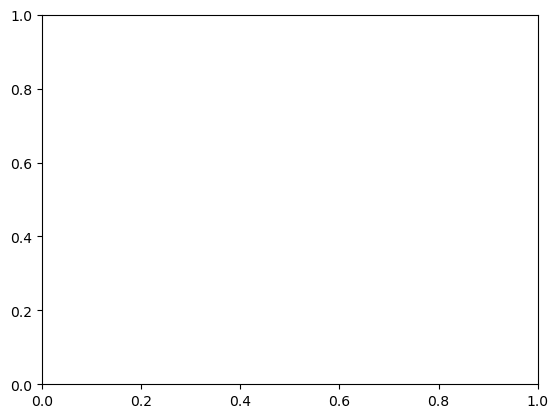

In [5]:
from fine_tune import plot_regress
plot_regress(train_p=pred,train_t=label)

Loaded trained model with success.
RMSE(test)=4.9197001457214355
RMSE(train)=4.565899848937988


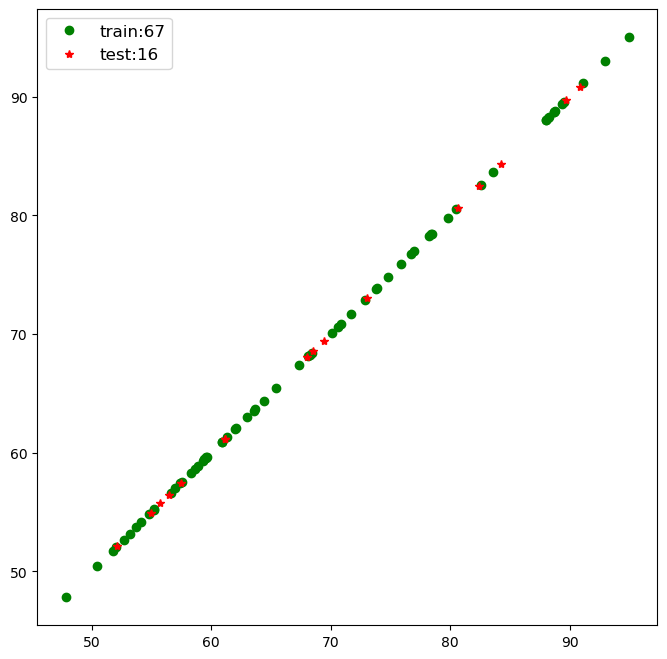

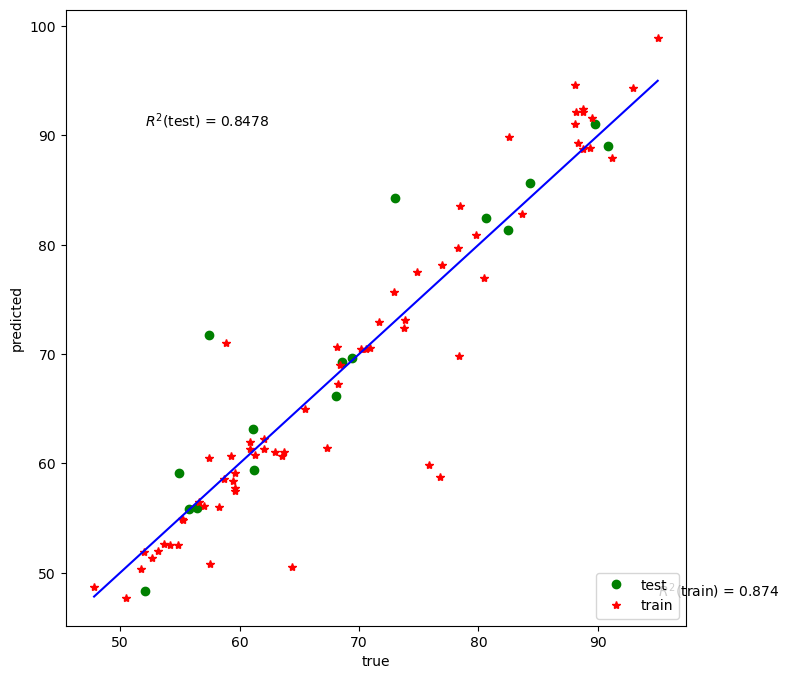

In [30]:
cu_model = FineTune(config=config,dataset=data_loader,model_path=pre_train_path)

In [3]:
df = pd.read_excel('./dataset/molecular_library/chembook.xlsx',0)
df = df.drop(df[pd.isna(df.smiles)].index)

In [6]:
df.index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            590, 591, 592, 593, 594, 595, 596, 597, 598, 599],
           dtype='int64', length=583)

In [7]:
smiles = df.smiles.to_list()
sample_ind = df.index

In [8]:
screen = [('Cu',smiles[i],sample_ind[i]) for i in range(len(smiles))]

In [15]:
dataset = target_dataset(screen)
data_loader = target_wrapper(predata=dataset,**config['data'])

Dataset generating......


In [16]:
temp = os.listdir('./experiment/finetune/2D/')
train,valid,test = data_loader.get_data_loaders()
path_list = ['./experiment/finetune/2D/'+p+'/checkpoints/' for p in temp]
preds = [[] for i in range(len(path_list))]
samples = []
models = [FineTune(config=config,model_path=path_list[i]) for i in range(len(path_list))]
for _,data in enumerate(train):
    for i,path in enumerate(path_list):
        preds[i].append(models[i].predict(data))
    samples.append(data.sample_ind)


normalizer!
normalizer!
normalizer!
normalizer!
normalizer!
normalizer!
normalizer!
normalizer!
normalizer!
normalizer!
normalizer!
normalizer!
normalizer!


In [17]:
temp = [np.concatenate(pred,axis=0)[np.newaxis,:] for pred in preds]
preds = np.concatenate(temp,axis=0)
pred = preds.mean(axis=0).tolist()

In [22]:
sampler = sum(samples,[])

In [26]:
df['Prediction'] = None

In [39]:
for i,ind in enumerate(sampler):
    df.loc[ind,'Prediction'] = pred[i]

In [52]:
df[df.Prediction>90]

,Name,CAS,MF,mw,Melting_point,Boiling_point,density,smiles,Prediction
13,Diphenylphosphinic acid,1707-03-5,C12H11O2P,218.19,193-195 °C(lit.),194 °C,1.25±0.1 g/cm3(Predicted),C1=CC=C(C=C1)P(=O)(C2=CC=CC=C2)O,91.468292
38,METHYLDIPHENYLPHOSPHINE OXIDE,2129-89-7,C13H13OP,216.22,111-115 °C (lit.),180 °C / 1mmHg,1.12±0.1 g/cm3(Predicted),CP(=O)(C1=CC=CC=C1)C2=CC=CC=C2,91.621178
39,Amino tris(methylene phosphonic acid),6419-19-8,C3H12NO9P3,299.05,~215 °C (dec.),746.2±70.0 °C(Predicted),1.3 g/mL at 25 °C,C(N(CP(=O)(O)O)CP(=O)(O)O)P(=O)(O)O,103.979729
57,3-Methyl-1-phenyl-2-phospholene 1-oxide,707-61-9,C11H13OP,192.19,58-62 °C,150 °C/0.15 mmHg (lit.),1.11±0.1 g/cm3(Predicted),CC1=CP(=O)(CC1)C2=CC=CC=C2,95.635796
120,DIPHENYLETHYLPHOSPHINE OXIDE,1733-57-9,C14H15OP,230.24,120-125 °C (lit.),179-180°C 14mm,"1,064 g/cm3",CCP(=O)(C1=CC=CC=C1)C2=CC=CC=C2,91.159615
137,HDTMPA,23605-74-5,C10H28N2O12P4,492.23,242 °C,546.04°C (rough estimate),1.4353 (rough estimate),C(CCCN(CP(=O)(O)O)CP(=O)(O)O)CCN(CP(=O)(O)O)CP...,119.778473
138,Bis(hexamethylenetriaminepenta(methylenephosph...,34690-00-1,C17H44N3O15P5,685.41,NaN,1002.7±75.0 °C(Predicted),1.24 g/mL at 20 °C,C(CCCN(CP(=O)(O)O)CP(=O)(O)O)CCN(CCCCCCN(CP(=O...,133.999283
147,ALLYLDIPHENYLPHOSPHINE OXIDE,4141-48-4,C15H15OP,242.25,110-114 °C(lit.),200-202 °C(Press: 2 Torr),1.0769 g/cm3,C=CCP(=O)(C1=CC=CC=C1)C2=CC=CC=C2,91.830566
186,2-(Triethylsilyl)ethyldiphenylphosphine oxide,922737-68-6,C20H29OPSi,344.50,110-110.5 °C,417.4±28.0 °C(Predicted),1.00±0.1 g/cm3(Predicted),CC[Si](CC)(CC)CCP(=O)(C1=CC=CC=C1)C2=CC=CC=C2,92.350464
222,Dichlorobis[(di-tert-butyl)(n-butyl)phosphine]...,1444507-24-7,C24H56Cl2P2Pd,583.98,NaN,NaN,NaN,C1=CC=C(C=C1)P(=O)(CC2=CC(=CC=C2)O)C3=CC=CC=C3,93.460686


In [42]:
with pd.ExcelWriter('./dataset/molecular_library/chembook.xlsx',mode='a') as writer:
    df.to_excel(writer,'Prediction')

In [47]:
screen = [('Cu','C1=CC=C(C=C1)P(=O)(C2=CC=CC=C2)O',0)]
d = target_dataset(screen)

Dataset generating......


In [48]:
preds = [[] for i in range(len(path_list))]
for i,path in enumerate(path_list):
    preds[i].append(models[i].predict(d[0]))

In [49]:
preds = sum(preds,[])

In [51]:
np.mean(preds)

91.4682693404778